In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
IMAGES_PATH = "../phase_1/data/flickr8k/images"  # Directory with training images
CAPTIONS_PATH = "../phase_1/data/flickr8k/captions.txt"  # Caption file
TEST_IMAGES_PATH = "../phase_1/test copy/"  # Directory with test images

In [3]:
import tqdm
import nltk 
from collections import Counter
from vocabulary_class  import Vocabulary
nltk.download('punkt_tab')
import json

tokens = []
counter = Counter()

import csv

def build_vocab(json_path, threshold=5, limit=None):
    
    counter = Counter()
    image_captions = {}
    count =0
    with open(CAPTIONS_PATH, "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        next(reader)  # skip header: image,caption

        for row in reader:
            if len(row) < 2:
                continue
            img_name, caption = row
            if img_name not in image_captions:
                    image_captions[img_name] = []
            image_captions[img_name].append(caption)

            caption = caption.lower()
            tokens = nltk.tokenize.word_tokenize(caption)
            counter.update(tokens)
            count +=1
            if limit and count >= limit:
                break
    
    vocab = Vocabulary()
    for word, cnt in counter.items():
        if cnt >= threshold:
            vocab.add_word(word)
    
    return vocab, image_captions

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
vocab, image_captions = build_vocab(CAPTIONS_PATH, threshold=5)
print("Total vocabulary size:", len(vocab))

Total vocabulary size: 3005


In [5]:
len(image_captions)

8091

In [6]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [7]:

from torch.nn.utils.rnn import pad_sequence
import torch

def collate_fn(batch):
    images, captions = zip(*batch)

    images = torch.stack(images, 0)

    lengths = torch.tensor([len(c) for c in captions])

    captions = pad_sequence(
        captions,
        batch_first=True,
        padding_value=0
    )

    return images, captions, lengths

In [8]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import nltk
import os
import random

# Update the folowing datset call class to handle flikr8k dataset formate


import torch
from torch.utils.data import Dataset
from PIL import Image
import nltk
import os
import random
import csv

class FlickrDataset(Dataset):
    def __init__(self, root, captions_path, vocab, transform=None, max_samples=None):
        self.root = root
        self.vocab = vocab
        self.transform = transform

        image_captions = {}
        with open(captions_path, "r", encoding="utf-8") as f:
            reader = csv.reader(f)
            next(reader)  # skip header: image,caption

            for row in reader:
                if len(row) < 2:
                    continue
                img_name, caption = row
                if img_name not in image_captions:
                        image_captions[img_name] = []
                image_captions[img_name].append(caption)
        # Load captions
        self.image_captions = image_captions

        self.image_ids = list(self.image_captions.keys())

        if max_samples:
            self.image_ids = self.image_ids[:max_samples]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        vocab = self.vocab
        img_name = self.image_ids[index]
        img_path = os.path.join(self.root, img_name)

        try:
            image = Image.open(img_path).convert("RGB")
        except:
            # Skip corrupted image
            return self.__getitem__((index + 1) % len(self.image_ids))

        if self.transform:
            image = self.transform(image)

        # Randomly select one caption per image
        caption = random.choice(self.image_captions[img_name])

        tokens = nltk.tokenize.word_tokenize(caption)

        caption_indices = [vocab.word2idx["<start>"]]
        caption_indices += [
            vocab.word2idx.get(token, vocab.word2idx["<unk>"])
            for token in tokens
        ]
        caption_indices.append(vocab.word2idx["<end>"])

        caption_tensor = torch.tensor(caption_indices)

        return image, caption_tensor


In [9]:
from torch.utils.data import DataLoader
# from flickr_dataset  import FlickrDataset 

train_dataset = FlickrDataset(
    root=IMAGES_PATH,
    captions_path=CAPTIONS_PATH,
    vocab=vocab,
    transform=transform,
    max_samples=None
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    collate_fn= collate_fn
)


In [10]:
print(len(train_dataset))

8091


In [11]:
image, caption = train_dataset[0]

print(type(image))
print(image.shape)        # after transform
print(caption)
print(len(caption))

<class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([ 1,  3, 18, 19, 20,  4, 21, 22, 17,  2])
10


In [12]:
import torch.nn as nn
import torchvision.models as models
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from attention import Attention
import timm
    
class AttentionEncoderViT(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.vit = timm.create_model(
            "vit_base_patch16_224",
            pretrained=True,
            num_classes=0   # returns features directly
        )
        for p in self.vit.parameters():
            p.requires_grad = False

        self.feat_dim = self.vit.num_features  # 768
        self.proj = nn.Linear(self.feat_dim, embed_size)

    def forward(self, images):
        """
        images: [B, 3, 224, 224]
        returns: [B, N, embed_size]
        """
        # timm returns patch tokens if forward_features is used
        tokens = self.vit.forward_features(images)  # [B, N+1, 768]

        # Remove CLS token
        patch_tokens = tokens[:, 1:, :]             # [B, N, 768]

        patch_tokens = self.proj(patch_tokens)      # [B, N, embed_size]
        return patch_tokens
    
class AttentionDecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, encoder_dim, attention_dim, dropout=0.3):
        super(AttentionDecoderRNN, self).__init__()

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(attention_dim=attention_dim, decoder_dim=hidden_size, encoder_dim=encoder_dim)
        # self.lstm = nn.LSTMCell(
        #     embed_size+encoder_dim,
        #     hidden_size
        # )
        
        self.lstm = nn.LSTM(
            input_size=embed_size + encoder_dim,
            hidden_size=hidden_size,
            batch_first=True
        )
        # self.text_proj = nn.Linear(hidden_size, embed_size)
        self.text_lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.sent_proj = nn.Linear(hidden_size, embed_size)   # sentence embedding for retrieval

        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def init_hidden_state(self, encoder_out):
        batch_size = encoder_out.size(0)
        device = encoder_out.device
        h = torch.zeros(1, batch_size, self.lstm.hidden_size).to(device)
        c = torch.zeros(1, batch_size, self.lstm.hidden_size).to(device)
        return h, c
    
    def forward(self, encoder_out, captions, lengths):
        """
        encoder_out: [B, 49, 2048]
        captions:    [B, max_len]
        lengths:     [B]
        """

        batch_size = encoder_out.size(0)
        max_len = lengths.max().item() - 1  # remove <end>

        # ---- Teacher forcing: feed caption[:-1] ----
        captions_in = captions[:, :-1]   # remove <end> token

        embeddings = self.embed(captions_in)    # [B, T-1, embed_size]
        h, c = self.init_hidden_state(encoder_out)

        outputs = torch.zeros(batch_size, max_len, self.linear.out_features).to(encoder_out.device)
        alphas = torch.zeros(batch_size, max_len, encoder_out.size(1)).to(encoder_out.device)

        for t in range(max_len):
            batch_size_t = sum(l > t for l in lengths)

            context, alpha = self.attention(
                encoder_out[:batch_size_t],
                h[0, :batch_size_t, :]
            )

            lstm_input = torch.cat([embeddings[:batch_size_t, t, :], context], dim=1).unsqueeze(1)
            # shape: (batch_size_t, 1, embed+encoder_dim)

            output, (h_new, c_new) = self.lstm(
                lstm_input,
                (h[:, :batch_size_t, :].contiguous(),
                c[:, :batch_size_t, :].contiguous())
            )

            # output: (batch_size_t, 1, hidden) -> squeeze the time dim
            output = output.squeeze(1)   # (batch_size_t, hidden)

            # ❗ Create new tensors instead of in-place assignment
            h = torch.cat([h_new, h[:, batch_size_t:, :]], dim=1)
            c = torch.cat([c_new, c[:, batch_size_t:, :]], dim=1)

            preds = self.linear(self.dropout(output.squeeze(1)))

            outputs[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return outputs, alphas


In [13]:
# from model import AttentionEncoderViT, AttentionDecoderRNN
import torch.nn as nn

encoder = AttentionEncoderViT(embed_size=256).to(device)
decoder = AttentionDecoderRNN(embed_size=256, hidden_size=512, vocab_size=len(vocab), encoder_dim=256, attention_dim=512).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx["<pad>"])

params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)


In [ ]:
train_losses = []
for epoch in range(10):
    total_train_loss = 0
    for images, captions, lengths in tqdm.tqdm(train_loader):
        images = images.to(device)
        captions = captions.to(device)

        optimizer.zero_grad()
        
        features = encoder(images)
        outputs, alphas = decoder(features, captions, lengths)   # <-- IMPORTANT
        targets = captions[:, 1:]           # shift left
        targets = targets[:, :outputs.size(1)]    # trim to max_decode
        loss = criterion(
            outputs.reshape(-1, outputs.size(-1)),
            targets.reshape(-1)
        )

        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch}: Train={avg_train_loss:.4f}")

100%|██████████| 253/253 [01:22<00:00,  3.07it/s]

Epoch 0: Train=4.7109


In [26]:
def generate_caption(image, encoder, decoder, vocab, max_len=20):
    encoder.eval()
    decoder.eval()

    device = next(decoder.parameters()).device

    # ---- Encode image ----
    image = image.unsqueeze(0).to(device)      # [1, 3, 224, 224]
    encoder_out = encoder(image)                # [1, 49, 2048]

    # ---- Init hidden state ----
    h, c = decoder.init_hidden_state(encoder_out)

    # ---- Start token ----
    word = torch.tensor([vocab('<start>')]).to(device)

    caption = []

    for _ in range(max_len):
        # ---- Word embedding ----
        embedding = decoder.embed(word)         # [1, embed_size]

        # ---- Attention ----
        context, _ = decoder.attention(encoder_out, h[0])  # [1, 2048]

        # ---- LSTMCell input ----
        lstm_input = torch.cat([embedding, context], dim=1).unsqueeze(1)

        output, (h, c) = decoder.lstm(lstm_input, (h, c))

        # ---- Predict next word ----
        logits = decoder.linear(output.squeeze(1))  # (1, vocab_size)
        predicted = logits.argmax(dim=1)

        word_id = predicted.item()
        word = predicted

        if vocab.idx2word[word_id] == '<end>':
            break

        caption.append(vocab.idx2word[word_id])

    return ' '.join(caption)


In [16]:
torch.save(encoder.state_dict(), "models/encoder.pth")
torch.save(decoder.state_dict(), "models/decoder.pth")
torch.save(vocab, "models/vocab.pkl")

In [17]:
# from model import AttentionEncoderViT, AttentionDecoderRNN

vocab = torch.load("models/vocab.pkl", weights_only=False)
encoder = AttentionEncoderViT(256).to(device)
decoder = AttentionDecoderRNN(
    256,
    512,
    len(vocab),
    encoder_dim=256, attention_dim=512
).to(device)

encoder.load_state_dict(torch.load("models/encoder.pth", weights_only=True, map_location=device))
decoder.load_state_dict(torch.load("models/decoder.pth", weights_only=True, map_location=device), strict=False)

<All keys matched successfully>

In [18]:
from rouge_score import rouge_scorer

def tokens_to_string(tokens):
    if isinstance(tokens, list):
        return " ".join(tokens)
    return tokens

def compute_rouge_l(references, hypotheses):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    scores = []

    for refs, hyp in zip(references, hypotheses):
        hyp_str = tokens_to_string(hyp)

        rouge_l_scores = []
        for ref in refs:
            ref_str = tokens_to_string(ref)
            score = scorer.score(ref_str, hyp_str)['rougeL'].fmeasure
            rouge_l_scores.append(score)

        scores.append(max(rouge_l_scores))  # best reference

    return sum(scores) / len(scores)

from jiwer import wer
def compute_wer(references, hypotheses):
    """
    Computes WER using best matching reference per hypothesis
    """
    wers = []
    ref_tokens = []
    for refs in references:
        processed_refs = []
        for ref in refs:
            if isinstance(ref, list):
                processed_refs.append(ref)        # already tokenized
            else:
                processed_refs.append(ref.split()) # string → tokens
        ref_tokens.append(processed_refs)

    # Handle hypotheses
    hyp_tokens = []
    for hyp in hypotheses:
        if isinstance(hyp, list):
            hyp_tokens.append(hyp)
        else:
            hyp_tokens.append(hyp.split())

    for refs, hyp in zip(references, hypotheses):
        ref_wers = [wer(ref, hyp) for ref in refs]
        wers.append(min(ref_wers))  # Best match

    return sum(wers) / len(wers)

from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def compute_bleu4(references, hypotheses):
    """
    references: list of list of reference captions
    hypotheses: list of predicted captions
    """
    ref_tokens = []
    for refs in references:
        processed_refs = []
        for ref in refs:
            if isinstance(ref, list):
                processed_refs.append(ref)        # already tokenized
            else:
                processed_refs.append(ref.split()) # string → tokens
        ref_tokens.append(processed_refs)

    # Handle hypotheses
    hyp_tokens = []
    for hyp in hypotheses:
        if isinstance(hyp, list):
            hyp_tokens.append(hyp)
        else:
            hyp_tokens.append(hyp.split())


    smoothie = SmoothingFunction().method4

    bleu4 = corpus_bleu(
        ref_tokens,
        hyp_tokens,
        weights=(0.25, 0.25, 0.25, 0.25),
        # weights=(0, 0, 0, 0),
        smoothing_function=smoothie
    )

    return bleu4

In [19]:
# Bluen score caluclation
from nltk.translate.bleu_score import corpus_bleu
references = []
hypotheses = []
encoder.eval()
decoder.eval()
with torch.no_grad():
    for images, captions, lengths in tqdm.tqdm(train_loader):
        images = images.to(device)
        captions = captions.to(device)

        features = encoder(images)
        outputs, alphas = decoder(features, captions, lengths)   # <-- IMPORTANT

        _, predicted = outputs.max(2)  # [B, max_len]

        for i in range(captions.size(0)):
            ref = []
            for j in range(1, lengths[i]):  # remove <start> token
                ref.append(vocab.idx2word[captions[i][j].item()])
            references.append([ref])

            hyp = []
            for j in range(1, lengths[i]):  # remove <start> token
                hyp.append(vocab.idx2word[predicted[i][j-1].item()])
            hypotheses.append(hyp)
        
bleu4 = compute_bleu4(references, hypotheses)
print(f"blue 4 scores:: {bleu4:.4f}")

rougue_score = compute_rouge_l(references, hypotheses)
print(f"Rouge Score: {rougue_score:.4f}")

wer_score = compute_wer(references, hypotheses)
print(f"WER Score: {wer_score:.4f}")

100%|██████████| 253/253 [01:16<00:00,  3.31it/s]


blue 4 scores:: 0.0498
Rouge Score: 0.3633
WER Score: 0.6630


In [20]:
import torch
import torch.nn.functional as F

def recall_at_k(similarity, k):
    """
    similarity: [N, N] similarity matrix
    """
    topk = similarity.topk(k, dim=1).indices
    targets = torch.arange(similarity.size(0)).unsqueeze(1).to(similarity.device)
    correct = (topk == targets).any(dim=1)
    return correct.float().mean().item()

def extract_image_embeddings(dataloader, encoder, device):
    encoder.eval()
    image_embeddings = []

    with torch.no_grad():
        for images, _ , lengths in dataloader:
            images = images.to(device)
            patch_emb = encoder(images)               # [B, 196, 256]
            feats = patch_emb.mean(dim=1)            # [B, 256]
            feats = F.normalize(feats, dim=1)
            image_embeddings.append(feats)

    return torch.cat(image_embeddings, dim=0)       # [N, embed_size]

def extract_text_embeddings(dataloader, decoder, device):
    decoder.eval()
    all_sent = []

    with torch.no_grad():
        for images, captions, lengths in dataloader:
            captions = captions.to(device)
            lengths = torch.as_tensor(lengths).cpu()  # pack needs CPU lengths

            emb = decoder.embed(captions)  # (B, T, embed_size)

            packed = torch.nn.utils.rnn.pack_padded_sequence(
                emb, lengths, batch_first=True, enforce_sorted=False
            )

            _, (h, _) = decoder.text_lstm(packed)     # h: (1, B, hidden)
            sent = h[-1]                               # (B, hidden)
            sent = decoder.sent_proj(sent)             # (B, embed_size)

            # optional normalize (helps retrieval)
            sent = torch.nn.functional.normalize(sent, dim=1)

            all_sent.append(sent.cpu())

    return torch.cat(all_sent, dim=0)

def image_to_text_retrieval(image_emb, text_emb, batch_size=512):
    image_emb = image_emb.cuda()
    text_emb  = text_emb.cuda()

    N = image_emb.size(0)
    ranks = []

    for i in range(0, N, batch_size):
        img_batch = image_emb[i:i+batch_size]           # [B, D]
        sim = img_batch @ text_emb.T                     # [B, N]

        gt = torch.arange(i, min(i+batch_size, N)).cuda()
        sorted_idx = sim.argsort(dim=1, descending=True)

        for j in range(sorted_idx.size(0)):
            rank = (sorted_idx[j] == gt[j]).nonzero(as_tuple=True)[0].item()
            ranks.append(rank)

    ranks = torch.tensor(ranks)
    return {
        "R@1":  (ranks < 1).float().mean().item(),
        "R@5":  (ranks < 5).float().mean().item(),
        "R@10": (ranks < 10).float().mean().item()
    }

def text_to_image_retrieval(image_emb, text_emb, batch_size=512):
    image_emb = image_emb.cuda()
    text_emb  = text_emb.cuda()

    N = text_emb.size(0)
    ranks = []

    for i in range(0, N, batch_size):
        txt_batch = text_emb[i:i+batch_size]           # [B, D]
        sim = txt_batch @ image_emb.T                     # [B, N]

        gt = torch.arange(i, min(i+batch_size, N)).cuda()
        sorted_idx = sim.argsort(dim=1, descending=True)

        for j in range(sorted_idx.size(0)):
            rank = (sorted_idx[j] == gt[j]).nonzero(as_tuple=True)[0].item()
            ranks.append(rank)

    ranks = torch.tensor(ranks)
    return {
        "R@1":  (ranks < 1).float().mean().item(),
        "R@5":  (ranks < 5).float().mean().item(),
        "R@10": (ranks < 10).float().mean().item()
    }

def text_to_text_retrieval(text_emb, batch_size=512):
    text_emb  = text_emb.cuda()

    N = text_emb.size(0)
    ranks = []

    for i in range(0, N, batch_size):
        txt_batch = text_emb[i:i+batch_size]           # [B, D]
        sim = txt_batch @ text_emb.T                     # [B, N]
        sim.fill_diagonal_(-1)

        gt = torch.arange(i, min(i+batch_size, N)).cuda()
        sorted_idx = sim.argsort(dim=1, descending=True)

        for j in range(sorted_idx.size(0)):
            rank = (sorted_idx[j] == gt[j]).nonzero(as_tuple=True)[0].item()
            ranks.append(rank)

    ranks = torch.tensor(ranks)
    return {
        "R@1":  (ranks < 1).float().mean().item(),
        "R@5":  (ranks < 5).float().mean().item(),
        "R@10": (ranks < 10).float().mean().item()
    }

# def image_to_image_retrieval(image_emb, batch_size=512):
#     image_emb  = image_emb.cuda()

#     N = image_emb.size(0)
#     ranks = []

#     for i in range(0, N, batch_size):
#         img_batch = image_emb[i:i+batch_size]           # [B, D]
#         sim = img_batch @ image_emb.T                     # [B, N]
#         sim.fill_diagonal_(-1)

#         gt = torch.arange(i, min(i+batch_size, N)).cuda()
#         sorted_idx = sim.argsort(dim=1, descending=True)

#         for j in range(sorted_idx.size(0)):
#             rank = (sorted_idx[j] == gt[j]).nonzero(as_tuple=True)[0].item()
#             ranks.append(rank)

#     ranks = torch.tensor(ranks)
#     return {
#         "R@1":  (ranks < 1).float().mean().item(),
#         "R@5":  (ranks < 5).float().mean().item(),
#         "R@10": (ranks < 10).float().mean().item()
#     }

def image_to_image_retrieval(image_emb):
    sim = image_emb @ image_emb.t()

    # Remove self-matching
    sim.fill_diagonal_(-1)

    return {
        "R@1": recall_at_k(sim, 1),
        "R@5": recall_at_k(sim, 5),
        "R@10": recall_at_k(sim, 10),
    }

In [21]:
image_emb = extract_image_embeddings(train_loader, encoder, device)



In [22]:
text_emb  = extract_text_embeddings(train_loader, decoder, device)

In [23]:
print(image_emb.shape)  # [num_images, 256]
print(text_emb.shape)   # [num_images*5, 256]


torch.Size([8091, 256])
torch.Size([8091, 256])


In [24]:
print("Image → Text:", image_to_text_retrieval(image_emb, text_emb))
print("Text → Image:", text_to_image_retrieval(image_emb, text_emb))
print("Text → Text :", text_to_text_retrieval(text_emb))
print("Image → Image:", image_to_image_retrieval(image_emb))

Image → Text: {'R@1': 0.0, 'R@5': 0.0004943764652125537, 'R@10': 0.0013595352647826076}
Text → Image: {'R@1': 0.0, 'R@5': 0.00037078236346133053, 'R@10': 0.0012359411921352148}
Text → Text : {'R@1': 0.9348658919334412, 'R@5': 0.9364725947380066, 'R@10': 0.9367198348045349}
Image → Image: {'R@1': 0.0, 'R@5': 0.0, 'R@10': 0.0}


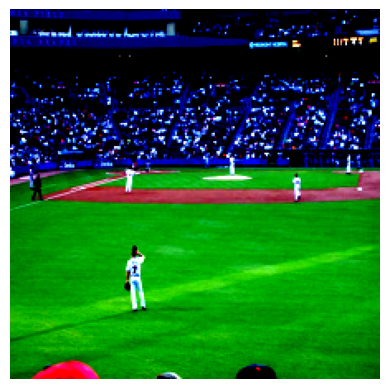

Image: 134206.jpg
Caption: <unk> man in a red shirt is playing in the air .



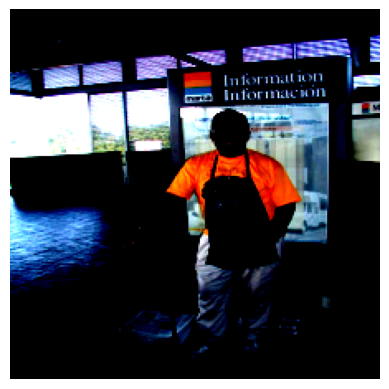

Image: 148284.jpg
Caption: <unk> man in a red shirt is standing on a <unk> .



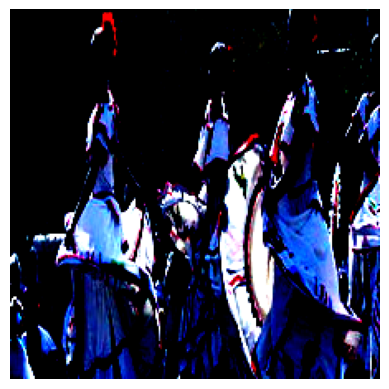

Image: 178045.jpg
Caption: <unk> man in a red shirt is standing on a <unk> .



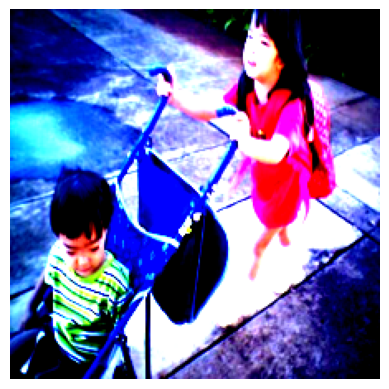

Image: 205842.jpg
Caption: <unk> little girl in a red shirt is standing on a <unk> .



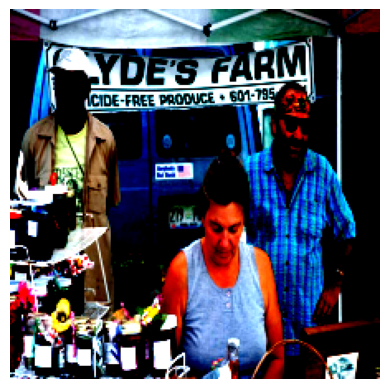

Image: 256063.jpg
Caption: <unk> man in a red shirt is standing on a <unk> .



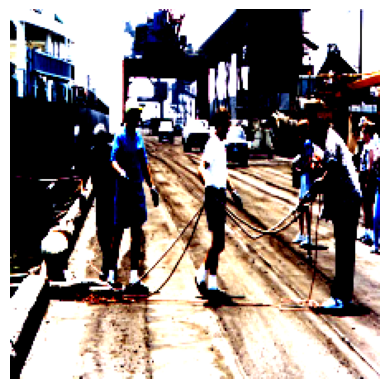

Image: 301246.jpg
Caption: <unk> people are sitting on a <unk> .


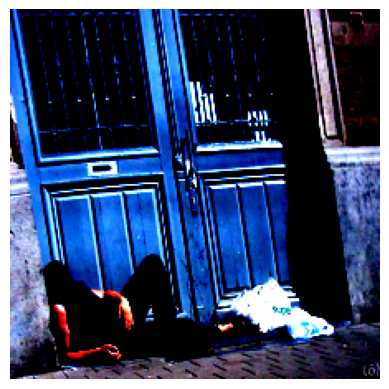

Image: 353913.jpg
Caption: <unk> man in a red shirt is sitting on a street .



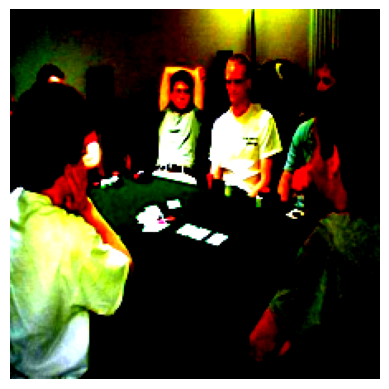

Image: 36979.jpg
Caption: <unk> woman in a red shirt is standing on a <unk> .


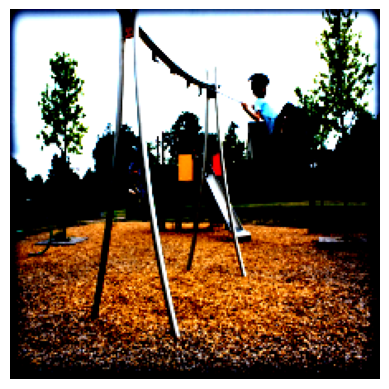

Image: 3717809376_f97611ab84.jpg
Caption: <unk> man in a red shirt is jumping on a swing .



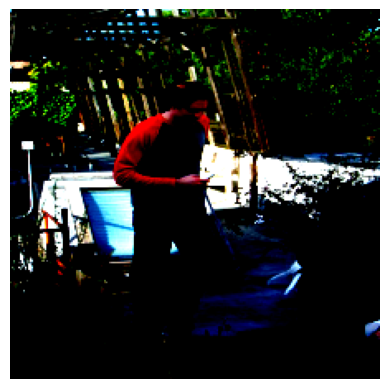

Image: 371897.jpg
Caption: <unk> man in a red shirt is jumping on a <unk> .



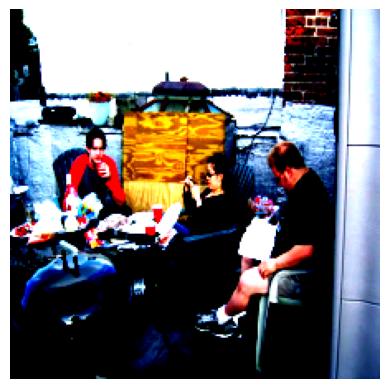

Image: 371902.jpg
Caption: <unk> man in a red shirt is standing on a <unk> .


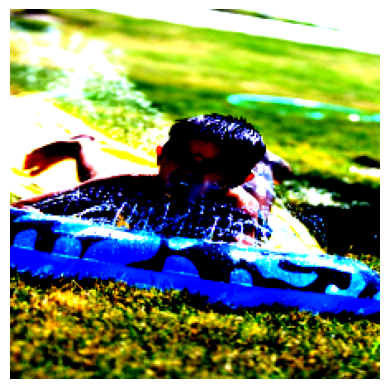

Image: 3759230208_1c2a492b12.jpg
Caption: <unk> boy is jumping in a pool .



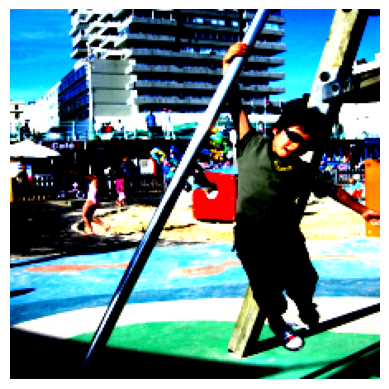

Image: 3759492488_592cd78ed1.jpg
Caption: <unk> boy in a red shirt is jumping on a swing .


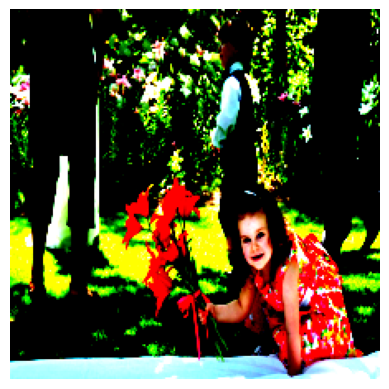

Image: 3760400645_3ba51d27f9.jpg
Caption: <unk> girl in a red shirt is sitting on a <unk> .



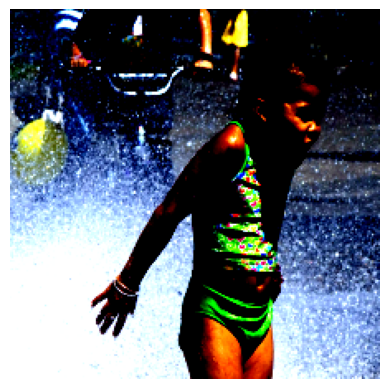

Image: 3765374230_cb1bbee0cb.jpg
Caption: <unk> girl in a red shirt is jumping in a pool .



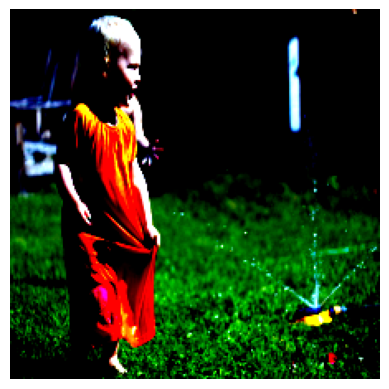

Image: 3767841911_6678052eb6.jpg
Caption: <unk> boy in a red shirt is jumping in a pool .



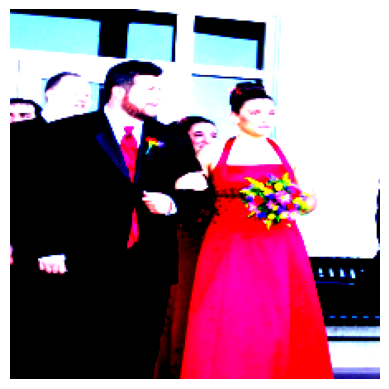

Image: 65567.jpg
Caption: <unk> man in a red shirt is standing in a <unk> .



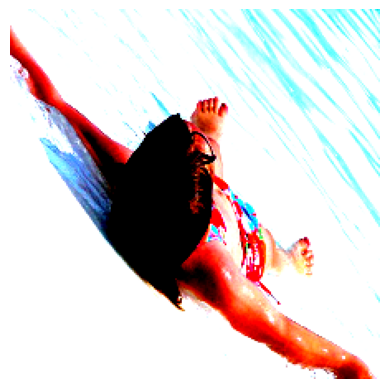

Image: 667626_18933d713e.jpg
Caption: <unk> girl in a red shirt is jumping in a pool .



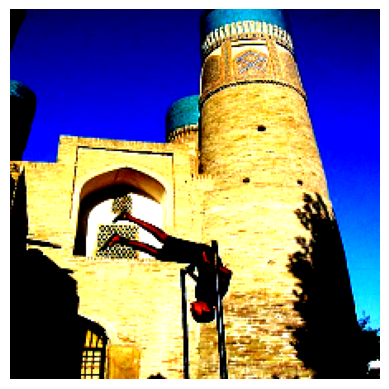

Image: 81641.jpg
Caption: <unk> man is jumping on a rock .



In [27]:
#  test the model on a few images
import os
import matplotlib.pyplot as plt
from PIL import Image

for file_name in os.listdir(TEST_IMAGES_PATH)[:20]:
    # Load image
    img_path = f"{TEST_IMAGES_PATH}/{file_name}"
    image = Image.open(img_path).convert("RGB")

    image = transform(image)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()
    
    caption = generate_caption(image, encoder, decoder, vocab)
    print(f"Image: {file_name}\nCaption: {caption}\n")
